# Sequence-to-Sequence Learning for Romanian Grapheme-to-Phoneme Conversion

### This notebook can be used to replicate the results reported in the paper: 

> Adriana Stan, *”Input Encoding for Sequence-to-Sequence Learning of Romanian Grapheme-to-Phoneme Conversion”*, In Proceedings of the 10th Conference on Speech Technology and Human-Computer Dialogue, Timișoara, Romania, 2019, https://sped.pub.ro/


The notebook is based on Keras's tutorial on sequence-to-sequence learning: https://keras.io/examples/lstm_seq2seq/


**License**: The work is under a GNU General Public License v3.0 

## 1) Prerequisites

The notebook is meant to be run on Google Colab's app. It can, however, be run on you local Jupyter server or as simple Python code.

It uses the Keras toolkit with Tensorflow backend: http://keras.io 


If you would like to use the letter embeddings, you also need the `gensim` module. 

In [1]:
# Mount the Google drive or upload your data to Colab
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#!pip3 install gensim

## 2) Data preparation

Download the MarePhor Romanian phonetic dictionary from: https://speech.utcluj.ro/marephor/. If you want to use the additional lexical stress positioning and syllabification you also need to obtain the DexOnline and RoSyllabiDict databases and process the data from within. 

Process the input data so that each line contains the input sequence followed by the phonetic sequence and separated by a vertical bar '|'. E.g.:

> `A|a`

> `AALBOAIEI|a a l b o_X a j e j`

> `AALEXOAIEI|a a l e ks o_X a j e j`

> `AANCUȚEI|a a n k u ts e j`


or if you use the additional lexical features, just make sure that there are separate markers for syllabification and lexical stress

> `a-al-bo'a-iei|a a l b o_X a j e j`

> `a-a-le-xo'a-iei|a a l e ks o_X a j e j`

> `a-an-cu-ț'ei|a a n k u ts e j`

> `a-a-ni-c'ăi|a a n i k @ j`


Separate the data into train and test sets and name them accordingly.

The **letter embeddings** created from the Wikipedia dump are available in the Github repository alonside this notebook. 


## 3) Read the data

In [4]:
from __future__ import print_function
import numpy as np
import random as r
import sys

# Path to the data files on disk
# Change these accordingly
data_path = '/content/gdrive/My Drive/Colab Notebooks/PHONETIC_TRANSCRIPTION_SPED/marephor_phonetic_corpus_TRAIN'
test_data_path = '/content/gdrive/My Drive/Colab Notebooks/PHONETIC_TRANSCRIPTION_SPED/marephor_phonetic_corpus_TEST'


# Read the train data file

# number of samples to use for training/testing (-1 all)
n_train = 1000
n_test = 20

# MarePhor contains a special symbol for phones which are not read '='
# We will remove it from the transcription.
lines = []
with open(data_path, 'r') as f:
    data = [x.strip().split('|') for x in f.readlines()[:n_train]]
    for i in range(len(data)):
       lines.append([data[i][0].lower(), ' '.join(data[i][1:]).replace(' =','')]) 


# Read the test data file        
test_lines = []
with open(test_data_path, 'r') as f:
    test_data = [x.strip().split('|') for x in f.readlines()[:n_test]]
    for i in range(len(test_data)):
       test_lines.append([test_data[i][0].lower(), ' '.join(test_data[i][1:]).replace(' =','')])


## Shuffle the data so that the batches do not contain
# alphabetically ordered words
r.shuffle(lines) 
r.shuffle(test_lines)

# Get some numbers from the data
num_train_samples = len(lines)   
num_test_samples = len(test_lines)


# Prepare some variables which will hold the data and stats

# train
input_texts = []
target_texts = []
# test
test_input_texts = []
test_target_texts = []
# set of input and target characters
input_characters = set()
target_characters = set()

# Add the start and end of sequence markers to the set of target characters
target_characters.add('~')
target_characters.add('!')


# Process train and test indexes and create the sets of input and target chars
for ind in range(num_train_samples):
    input_texts.append(lines[ind][0])
    # append the start and end of sequence markers
    target_texts.append('~ '+lines[ind][1][:]+' !')
    for char in set(lines[ind][0]):
        if char not in input_characters:
            input_characters.add(char)
    for char in set(lines[ind][1].split()):
        if char not in target_characters:
            target_characters.add(char)

for ind in range(num_test_samples):
    test_input_texts.append(test_lines[ind][0])
    # append the start and end of sequence markers
    test_target_texts.append('~ '+test_lines[ind][1][:]+' !')
    for char in set(test_lines[ind][0]):
        if char not in input_characters:
            input_characters.add(char)    
    for char in set(test_lines[ind][1].split()):
        if char not in target_characters:
            target_characters.add(char)

# Create more variables and numbers required for training
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
test_max_encoder_seq_length = max([len(txt) for txt in test_input_texts])
test_max_decoder_seq_length = max([len(txt) for txt in test_target_texts])

# Maximum length of input and target sequences
max_encoder_seq_length = max(max_encoder_seq_length, test_max_encoder_seq_length)
max_decoder_seq_length = max(max_decoder_seq_length, test_max_decoder_seq_length)

# Convert chars to integers
input_token_index = dict(
            [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
            [(char, i) for i, char in enumerate(target_characters)])

# Create the reverse dict: integers to chars
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


# Print some stats
print('Number of TRAIN samples:', len(input_texts))
print('Number of TEST samples:', len(test_input_texts))
print('Number of unique input tokens - num_encoder_tokens:', num_encoder_tokens)
print('Number of unique output tokens - num_decoder_tokens:', num_decoder_tokens)
print('Max sequence length for inputs - max_encoder_seq_length:', max_encoder_seq_length)
print('Max sequence length for outputs - max_decoder_seq_length:', max_decoder_seq_length)

print ('Set of input characters:', input_characters)
print ('Set of target characters:', target_characters)

# Print a sample of the training data
print ("Training data sample: ", input_texts[10], target_texts[10]) 

Number of TRAIN samples: 1000
Number of TEST samples: 20
Number of unique input tokens - num_encoder_tokens: 26
Number of unique output tokens - num_decoder_tokens: 36
Max sequence length for inputs - max_encoder_seq_length: 15
Max sequence length for outputs - max_decoder_seq_length: 35
Set of input characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'x', 'z', 'â', 'ă', 'ș', 'ț']
Set of target characters: ['!', '1', '@', 'S', 'Z', 'a', 'b', 'd', 'dZ', 'e', 'e_X', 'f', 'g', 'h', 'i', 'i_0', 'j', 'k', 'k_j', 'ks', 'l', 'm', 'n', 'o', 'o_X', 'p', 'r', 's', 't', 'tS', 'ts', 'u', 'v', 'w', 'z', '~']
Training data sample:  acatagrafie ~ a k a t a g r a f i e !


## 4) Batch Generators

As loading the data into memory at once might pose problems, it is more common to use a batch generator for training. This class prepares the batches on the fly without the need to load it all at once.


Depending on the input encoding you want to use: one-hot encoding or letter embeddings, set the `encoding` variable accordingly:

In [0]:
# What input encoding to use
#        - OHE - one-hot encoding
#        - LE - letter embeddings
input_encoding = 'LE'

In [6]:
# Read the letter embeddings and create random ones for the start and end
# of sequence markers

if input_encoding == 'LE':
  from gensim.models import Word2Vec  
  model = Word2Vec.load("/content/gdrive/My Drive/Colab Notebooks/PHONETIC_TRANSCRIPTION_SPED/rowiki_letter_30.model")  
  le = model.wv  
  le["~"] = np.array([0.0e-4]*model.wv.vector_size)
  le["-"] = np.array([0.2e-4]*len(le["a"]))
  le["'"] = np.array([0.1e-4]*len(le["a"]))  



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
from keras.utils import Sequence
# This class is used to load in the data in batches by the specified batch_size 
# (all your data might not fit at once in the memory). 
# It loads the data in batches and normalizes each batch with max
class BatchGenerator(Sequence):

    def __init__(self, input_encoding, num_of_lines, batch_size, input_text, target_text, 
                 input_characters, target_characters, num_encoder_tokens, 
                 num_decoder_tokens, max_encoder_seq_length, 
                 max_decoder_seq_length, input_token_index, target_token_index):

        self.input_encoding = input_encoding
        self.num_of_lines = num_of_lines
        self.batch_size = batch_size
        self.input_text = input_text
        self.target_text = target_text
        self.input_characters = input_characters
        self.target_characters = target_characters
        self.num_encoder_tokens = num_encoder_tokens
        self.num_decoder_tokens = num_decoder_tokens
        self.max_encoder_seq_length = max_encoder_seq_length
        self.max_decoder_seq_length = max_decoder_seq_length
        self.input_token_index = input_token_index
        self.target_token_index = target_token_index

    def __len__(self):
        return int(np.ceil(self.num_of_lines / float(self.batch_size)))

    def __getitem__(self, idx):

        start_index = idx * self.batch_size
        if (idx + 1) * self.batch_size > self.num_of_lines:
            end_index = self.num_of_lines
        else:
            end_index = (idx + 1) * self.batch_size

        batch_x = self.input_text[start_index:end_index]
        batch_y = self.target_text[start_index:end_index]

        encoder_input_data = np.zeros(
            (len(batch_x), self.max_encoder_seq_length, self.num_encoder_tokens),
            dtype='float32')
        decoder_input_data = np.zeros(
            (len(batch_x), self.max_decoder_seq_length, self.num_decoder_tokens),
            dtype='float32')
        decoder_target_data = np.zeros(
            (len(batch_x), self.max_decoder_seq_length, self.num_decoder_tokens),
            dtype='float32')

        for i, (input_text, target_text) in enumerate(zip(batch_x, batch_y)):
            for t, char in enumerate(input_text):
                if self.input_encoding == 'LE':
                  encoder_input_data[i, t, :] = le[char]
                else:
                  encoder_input_data[i, t, input_token_index[char]] = 1.
            for t, char in enumerate(target_text.split()):
                # decoder_target_data is ahead of decoder_input_data by one timestep
                decoder_input_data[i, t, target_token_index[char]] = 1.
                if t > 0:
                    # decoder_target_data will be ahead by one timestep
                    # and will not include the start character.
                    decoder_target_data[i, t - 1, target_token_index[char]] = 1.

        return [encoder_input_data, decoder_input_data], decoder_target_data

Using TensorFlow backend.


## 5) Setup the model

In [8]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense


batch_size = 32 # Batch size for training.
latent_dim = 512 # Latent dimensionality of the encoding space.

if input_encoding == 'LE':
  num_encoder_tokens = len(le['~'])


# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


# Prepare the batch generator
my_batch_generator = BatchGenerator(input_encoding, num_train_samples, batch_size, 
                       input_texts, target_texts, input_characters, target_characters, 
                       num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length,
                       max_decoder_seq_length, input_token_index, target_token_index)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])


## 6) Train the model

In [11]:
epochs = 10

print ("\nRunning on %d samples out of %d\n" %(len(input_texts),num_train_samples))
print ("Training on batchsize=%d for %d epochs with latent_dim=%d" %(batch_size, epochs, latent_dim))
history = model.fit_generator(generator=my_batch_generator, epochs=epochs)

# Save model for future use
model.save('s2s_phonetic.h5')


Running on 1000 samples out of 1000

Training on batchsize=32 for 10 epochs with latent_dim=512
Epoch 1/10
32/32 [==============================] - 3s 98ms/step - loss: 0.0252 - acc: 0.6916
Epoch 2/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0251 - acc: 0.6952
Epoch 3/10
32/32 [==============================] - 3s 95ms/step - loss: 0.0147 - acc: 0.7018
Epoch 4/10
32/32 [==============================] - 3s 95ms/step - loss: 0.0140 - acc: 0.6939
Epoch 5/10
32/32 [==============================] - 3s 95ms/step - loss: 0.0173 - acc: 0.7052
Epoch 6/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0130 - acc: 0.7241
Epoch 7/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0126 - acc: 0.6931
Epoch 8/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0128 - acc: 0.6904
Epoch 9/10
32/32 [==============================] - 3s 98ms/step - loss: 0.0104 - acc: 0.6794
Epoch 10/10
32/32 [==============================] - 3s 9

In [0]:
# Train more epochs? Uncomment the lines below

#history = model.fit_generator(generator=my_batch_generator, epochs=3)
#model.save('s2s_phonetic.h5')

## 7) Plot the training history

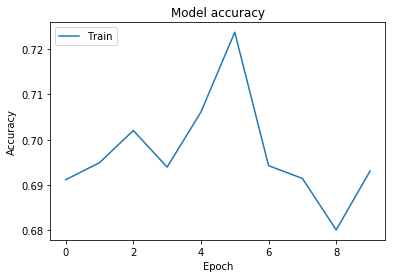

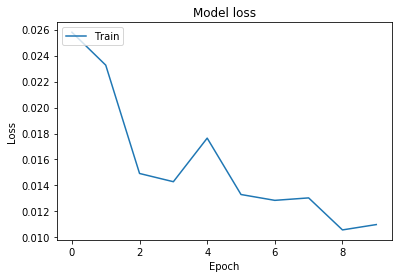

In [12]:
# Plot the model?
#from keras.utils import plot_model
#plot_model(model, to_file='model.pdf')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 8) Evaluate the model

We don't want to check just the metrics on the test set, but to also see the predicted phone transcription. The following function decodes the output sequence into readable characters:

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['~']] = 1.

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
       
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '!' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence[:-1]

We also need to process the test data into the same format as the training data:

In [0]:
def process_test_data(test_input_text, test_target_text):
  
    encoder_input_data = np.zeros(
        (1, max_encoder_seq_length, num_encoder_tokens),
        dtype='float32')
    decoder_input_data = np.zeros(
        (1, max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')
    decoder_target_data = np.zeros(
        (1, max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')

    for t, char in enumerate(test_input_text):
        if input_encoding == 'LE':
          encoder_input_data[0, t, :] = le[char]
        else: 
          encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(test_target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[0, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[0, t - 1, target_token_index[char]] = 1.

    return encoder_input_data, decoder_input_data, decoder_target_data

Also, we need to setup the model for inference:

In [0]:
encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

And finally get some numbers and predictions out:

In [16]:
total_loss = 0
total_acc = 0
total = 0
err = 0
print ("INPUT".ljust(20), "TARGET".ljust(40), "DECODED".ljust(40))

char_total = 0
char_err = 0

for i in range(len(test_input_texts)):
    
    encoder_input_data, decoder_input_data, decoder_target_data = process_test_data(test_input_texts[i], test_target_texts[i])
    zz = decode_sequence(encoder_input_data)
    tgt = test_target_texts[i].replace('~ ','').replace(' !','')
    
    zz_chars = zz.strip().split()
    tgt_chars = tgt.strip().split()
    
    if (zz.strip() != tgt.strip()):
      print(test_input_texts[i].strip().ljust(20), tgt.strip().ljust(40), zz.strip().ljust(40))
      err += 1
      for j in range(min(len(tgt_chars), len(zz_chars))):
        if tgt_chars[j]!=zz_chars[j]:
           char_err +=1
    char_total += len(tgt.strip().split())
    total +=1  
    if total % 500 == 0:
      print (total)
    
print ("\n****\nAccuracy at character level %.4f " %(float(char_total-char_err)/char_total))      
print ("\n****\nAccuracy at word level %.4f " %(float(total-err)/total))

INPUT                TARGET                                   DECODED                                 
abisinian            a b i s i n i a n                        a b i tS i n o n                        
abacă                a b a k @                                a b a t @                               
abitație             a b i t a ts i e                         a b i ts i ts i e                       
abătu                a b @ t u                                a b @ t a                               
abatesă              a b a t e s @                            a b a t e r k                           
abătut               a b @ t u t                              a b @ t a t                             
ablefarie            a b l e f a r i e                        a b l e p a i e                         
aberant              a b e r a n t                            a b e r e_X a n t                       
abductor             a b d u k t o r                          a b Z u k a